In [1]:
!pip install tensorflow==2.8.0

     |████████████████████████████████| 462 kB 5.3 MB/s 


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [3]:
csv_path = "https://raw.githubusercontent.com/BearTS/TeamLosPolosHermanos-Technica22/ml/BTC-USD%20(1%20year).csv?token=GHSAT0AAAAAABOYTPGD4KPUTZQRMSCUWHXOYUI6XMQ"

In [4]:
df = pd.read_csv(csv_path)

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-05-20,36753.667969,42462.984375,35050.617188,40782.738281,40782.738281,88281943359
1,2021-05-21,40596.949219,42172.171875,33616.453125,37304.691406,37304.691406,82051616861
2,2021-05-22,37371.031250,38831.054688,35383.683594,37536.632813,37536.632813,57377273240
3,2021-05-23,37531.449219,38289.218750,31227.339844,34770.582031,34770.582031,78469274361
4,2021-05-24,34700.363281,39835.140625,34551.082031,38705.980469,38705.980469,67359584098


In [6]:
df.shape

(366, 7)

Text(0, 0.5, 'Closing Price in (USD)')

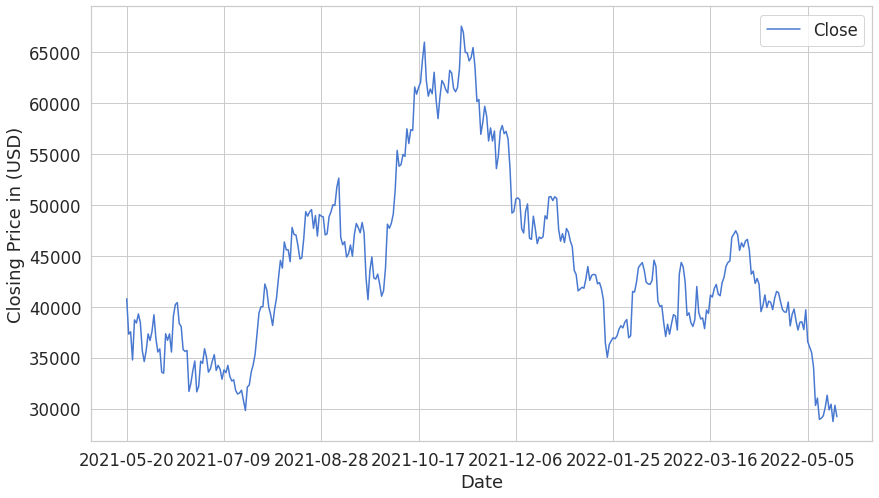

In [7]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price in (USD)")

# Normalization

In [8]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [9]:
scaled_close.shape

(366, 1)

In [10]:
np.isnan(scaled_close).any()

False

In [11]:
scaled_close = scaled_close.reshape(-1, 1)

# Preprocessing

In [12]:
SEQ_LEN = 20

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.8)

In [13]:
X_train.shape

(276, 19, 1)

In [14]:
X_test.shape

(70, 19, 1)

# Model

In [15]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [16]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [17]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
4/4 [==============================] - 23s 622ms/step - loss: 0.1730 - val_loss: 0.0135
Epoch 2/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0326 - val_loss: 0.0202
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0315 - val_loss: 0.0465
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0284 - val_loss: 0.0170
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0165 - val_loss: 0.0053
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0221 - val_loss: 0.0044
Epoch 7/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0194 - val_loss: 0.0056
Epoch 8/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0144 - val_loss: 0.0100
Epoch 9/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 10/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0134 - val_loss: 0.0104
Epoch 11/100
4/4 

In [18]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 10ms/step - loss: 0.0030


0.002987584564834833

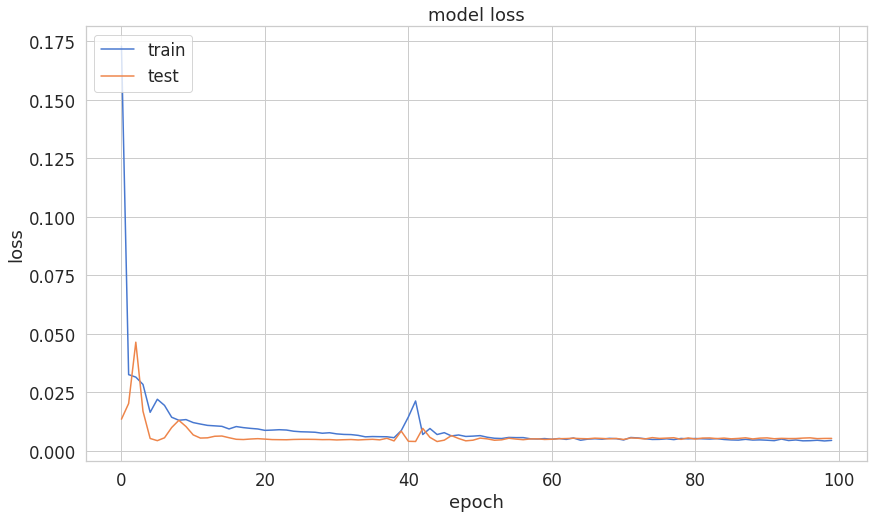

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

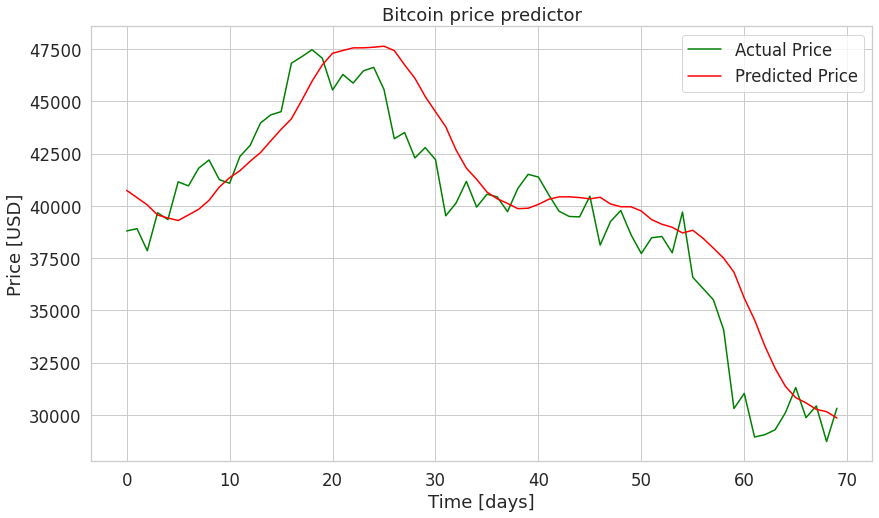

In [20]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price predictor')
plt.xlabel('Time [days]')
plt.ylabel('Price [USD]')
plt.legend(loc='best')
 
plt.show();